# 🌌 SDSS Star Detection and Photometry
This notebook processes Sloan Digital Sky Survey (SDSS) FITS images using Python. We will detect stars and perform background-subtracted aperture photometry across multiple spectral bands.

## 📦 Install Required Packages (if needed)
Uncomment and run these if the packages are not already installed.

In [2]:
!pip install photutils scikit-image astropy matplotlib numpy

## 📚 Import Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import ImageNormalize, AsinhStretch, PercentileInterval
from astropy.wcs import WCS
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from matplotlib.patches import Circle

## 🧭 Load and Display FITS Images

In [4]:
def load_fits_data(filename):
    with fits.open(filename) as hdul:
        return hdul[0].data

def plot_fits(image_data, band, vmin=5, vmax=99):
    plt.figure(figsize=(6, 6))
    plt.imshow(image_data, cmap='gray', origin='lower',
               vmin=np.percentile(image_data, vmin),
               vmax=np.percentile(image_data, vmax))
    plt.colorbar(label='Pixel Intensity')
    plt.title(f"SDSS A68 Cluster - Band {band}")
    plt.show()

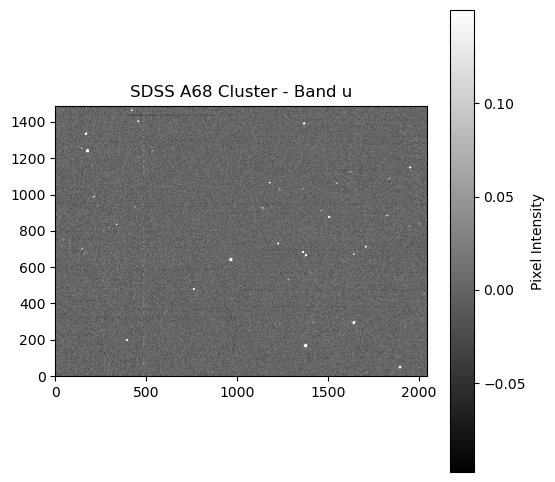

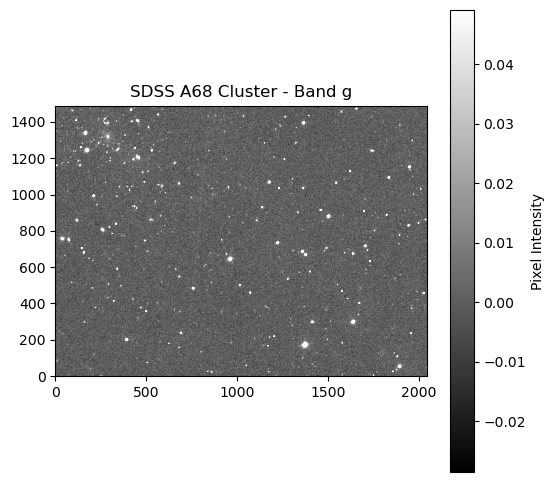

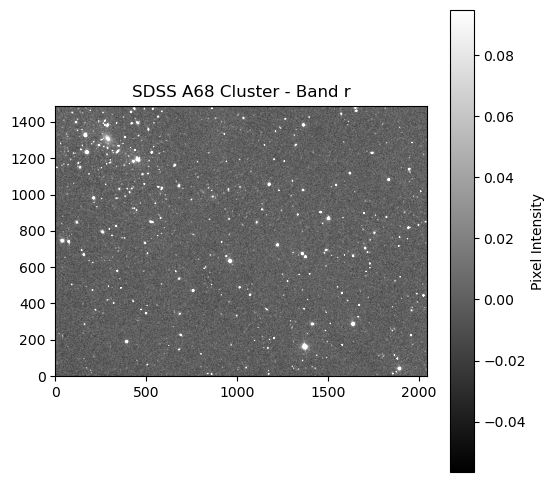

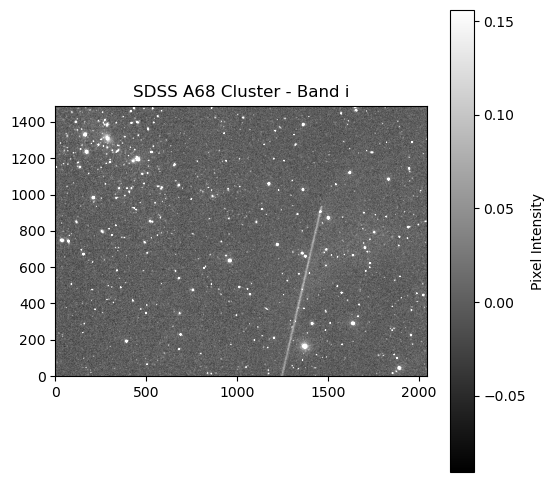

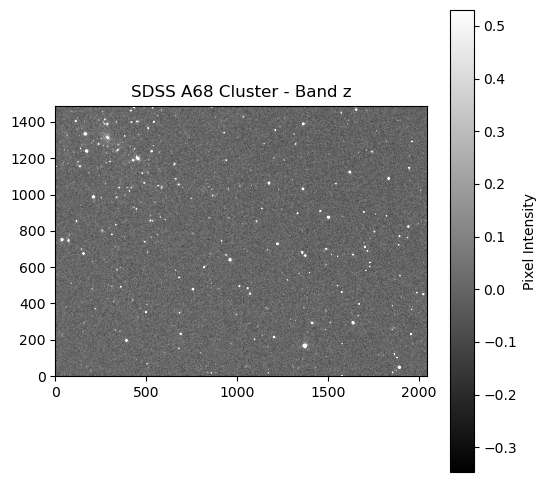

In [5]:
bands = ['u', 'g', 'r', 'i', 'z']
folder = 'fits_data'  # adjust if needed
data = {band: load_fits_data(f'{folder}/frame-{band}-007784-2-0257.fits') for band in bands}

for band in bands:
    plot_fits(data[band], band)

## ✨ Define Photometry Function

In [6]:
def measure_flux(fits_file, position, aperture_radius=5, annulus_r_in=8, annulus_r_out=12):
    with fits.open(fits_file) as hdul:
        image_data = hdul[0].data
        header = hdul[0].header

    nMgy_per_count = header.get('NMGY')
    if nMgy_per_count is None:
        raise ValueError("NMGY keyword not found in header.")

    aperture = CircularAperture(position, r=aperture_radius)
    annulus = CircularAnnulus(position, r_in=annulus_r_in, r_out=annulus_r_out)
    aper_stats = aperture_photometry(image_data, [aperture, annulus])

    raw_flux = aper_stats['aperture_sum_0'][0]
    bkg_flux = aper_stats['aperture_sum_1'][0]
    bkg_mean = bkg_flux / annulus.area
    bkg_total = bkg_mean * aperture.area
    net_flux = raw_flux - bkg_total
    flux_nMgy = net_flux * nMgy_per_count
    flux_mJy = flux_nMgy * 3.631e-6
    ab_mag = 22.5 - 2.5 * np.log10(flux_nMgy) if flux_nMgy > 0 else np.inf

    return {
        "Raw Flux (counts)": raw_flux,
        "Background-subtracted Flux (counts)": net_flux,
        "Flux (nMgy)": flux_nMgy,
        "Flux (mJy)": flux_mJy,
        "AB Magnitude": ab_mag
    }

## 📏 Measure Flux at a Star Position

Here I realised that the coordinates for each filter differ slightly! Hence 0 or infinity flux and ab magnitudes appear as its just empty space.

In [7]:
position = (961.21, 631.89)
frame_id = '007784-2-0257'
filters = ['u', 'g', 'r', 'i', 'z']

for f in filters:
    filename = f"fits_data/frame-{f}-{frame_id}.fits"
    result = measure_flux(filename, position)
    print(f"Filter: {f.upper()}")
    for k, v in result.items():
        print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")
    print()

Filter: U
  Raw Flux (counts): 8.4554
  Background-subtracted Flux (counts): -50.9046
  Flux (nMgy): -0.7096
  Flux (mJy): -0.0000
  AB Magnitude: inf

Filter: G
  Raw Flux (counts): 3.8326
  Background-subtracted Flux (counts): -133.2306
  Flux (nMgy): -0.6129
  Flux (mJy): -0.0000
  AB Magnitude: inf

Filter: R
  Raw Flux (counts): 1205.7523
  Background-subtracted Flux (counts): 1199.5063
  Flux (nMgy): 6.5702
  Flux (mJy): 0.0000
  AB Magnitude: 20.4560

Filter: I
  Raw Flux (counts): 1342.5344
  Background-subtracted Flux (counts): 1332.1661
  Flux (nMgy): 8.5330
  Flux (mJy): 0.0000
  AB Magnitude: 20.1722

Filter: Z
  Raw Flux (counts): 274.8517
  Background-subtracted Flux (counts): 218.7156
  Flux (nMgy): 7.6999
  Flux (mJy): 0.0000
  AB Magnitude: 20.2838



## 🌐 Cross-Band Coordinate Mapping with WCS

Next, I had to adjust for this by converting the coordinates to WCS, then finding the flux at each point now

In [8]:
import warnings
from astropy.utils.exceptions import AstropyWarning

warnings.simplefilter('ignore', category=AstropyWarning)


In [9]:
ref_file = 'fits_data/frame-r-007784-2-0257.fits'
ref_position = (961.208, 631.892)

with fits.open(ref_file) as hdul:
    ref_wcs = WCS(hdul[0].header)
    sky_coord = ref_wcs.pixel_to_world(*ref_position)

print(f"Sky coordinate: {sky_coord}")

for f in filters:
    file = f"fits_data/frame-{f}-{frame_id}.fits"
    with fits.open(file) as hdul:
        wcs = WCS(hdul[0].header)
        x, y = wcs.world_to_pixel(sky_coord)
        print(f"Filter {f.upper()} → Pixel position: ({x:.2f}, {y:.2f})")
        result = measure_flux(file, (x, y))
        for k, v in result.items():
            print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")
        print()

Sky coordinate: <SkyCoord (ICRS): (ra, dec) in deg
    (9.20464373, 9.23153264)>
Filter U → Pixel position: (964.91, 639.81)
  Raw Flux (counts): 281.3072
  Background-subtracted Flux (counts): 279.1209
  Flux (nMgy): 3.8911
  Flux (mJy): 0.0000
  AB Magnitude: 21.0248

Filter G → Pixel position: (961.68, 643.67)
  Raw Flux (counts): 815.5803
  Background-subtracted Flux (counts): 811.5781
  Flux (nMgy): 3.7337
  Flux (mJy): 0.0000
  AB Magnitude: 21.0696

Filter R → Pixel position: (961.21, 631.89)
  Raw Flux (counts): 1205.7425
  Background-subtracted Flux (counts): 1199.4955
  Flux (nMgy): 6.5702
  Flux (mJy): 0.0000
  AB Magnitude: 20.4561

Filter I → Pixel position: (960.02, 634.32)
  Raw Flux (counts): 1404.2514
  Background-subtracted Flux (counts): 1395.2307
  Flux (nMgy): 8.9370
  Flux (mJy): 0.0000
  AB Magnitude: 20.1220

Filter Z → Pixel position: (960.29, 637.83)
  Raw Flux (counts): 1436.4991
  Background-subtracted Flux (counts): 1424.9764
  Flux (nMgy): 50.1666
  Flux (

## 🖼️ Plot All Bands with Target Star

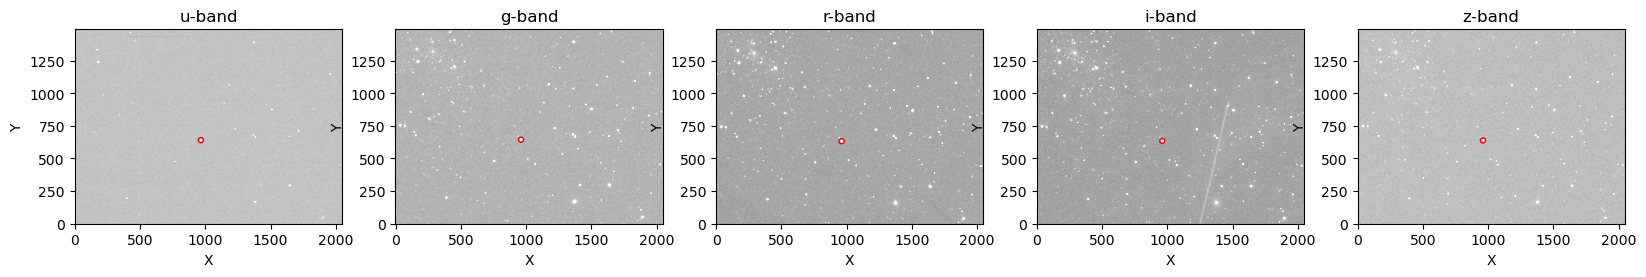

In [10]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, f in enumerate(filters):
    file = f"fits_data/frame-{f}-{frame_id}.fits"
    with fits.open(file) as hdul:
        data = hdul[0].data
        wcs = WCS(hdul[0].header)
        x, y = wcs.world_to_pixel(sky_coord)
        norm = ImageNormalize(data, interval=PercentileInterval(99.5), stretch=AsinhStretch())
        ax = axs[i]
        ax.imshow(data, origin='lower', cmap='gray', norm=norm)
        circ = Circle((x, y), radius=20, edgecolor='red', facecolor='none')
        ax.add_patch(circ)
        ax.set_title(f"{f}-band")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
plt.show()

## 📡 Sky-to-Pixel Mapping and Flux Measurement Across Bands
This final section uses the pixel coordinate from the r-band image to get the precise **sky coordinate**, 
then transforms that back to pixel coordinates in all bands (u, g, r, i, z) using WCS. 
We then measure flux using the same photometry method on each band-aligned position.


In [11]:
# Your original reference position (in pixels on r-band)
ref_position = (961.2081628457288, 631.8924039577129)
frame_id = "007784-2-0257"
filters = ['u', 'g', 'r', 'i', 'z']

# Step 1: Get sky coordinate from the r-band image at the reference position
ref_filename = f"fits_data/frame-r-{frame_id}.fits"
with fits.open(ref_filename) as ref_hdul:
    ref_wcs = WCS(ref_hdul[0].header)
    sky_coord = ref_wcs.pixel_to_world(ref_position[0], ref_position[1])

print(f"Measuring flux at sky coordinate (from r-band): {sky_coord}\n")

# Step 2: For each filter, convert sky coord back to pixel in that filter, then measure flux
for f in filters:
    filename = f"fits_data/frame-{f}-{frame_id}.fits"
    with fits.open(filename) as hdul:
        wcs = WCS(hdul[0].header)
        x, y = wcs.world_to_pixel(sky_coord)
        position = (x, y)
        print(f"Filter: {f.upper()} - Pixel position: ({x:.2f}, {y:.2f})")
        result = measure_flux(filename, position)
        for k, v in result.items():
            print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")
        print()


Measuring flux at sky coordinate (from r-band): <SkyCoord (ICRS): (ra, dec) in deg
    (9.20464377, 9.23153266)>

Filter: U - Pixel position: (964.91, 639.81)
  Raw Flux (counts): 281.3073
  Background-subtracted Flux (counts): 279.1207
  Flux (nMgy): 3.8911
  Flux (mJy): 0.0000
  AB Magnitude: 21.0248

Filter: G - Pixel position: (961.68, 643.67)
  Raw Flux (counts): 815.5807
  Background-subtracted Flux (counts): 811.5785
  Flux (nMgy): 3.7337
  Flux (mJy): 0.0000
  AB Magnitude: 21.0696

Filter: R - Pixel position: (961.21, 631.89)
  Raw Flux (counts): 1205.7418
  Background-subtracted Flux (counts): 1199.4946
  Flux (nMgy): 6.5702
  Flux (mJy): 0.0000
  AB Magnitude: 20.4561

Filter: I - Pixel position: (960.02, 634.32)
  Raw Flux (counts): 1404.2507
  Background-subtracted Flux (counts): 1395.2299
  Flux (nMgy): 8.9370
  Flux (mJy): 0.0000
  AB Magnitude: 20.1220

Filter: Z - Pixel position: (960.29, 637.83)
  Raw Flux (counts): 1436.4997
  Background-subtracted Flux (counts): 142